In [28]:
import os
import pandas as pd

res_path = '/home/gabi/diplomka/results/'
base_names = ['labeled_train', 'labeled_valid_unseen_networks-val_loss',
              'labeled_valid_unseen_images-val_loss',
             'labeled_valid_unseen_images-test_loss',
             'labeled_valid_unseen_images_nets-test_loss']

def process_res_directory(dir_path: str, with_baselines=True):
    loss_df = pd.read_csv(os.path.join(dir_path, 'loss.csv'), index_col=0)    
    metrics_df = pd.read_csv(os.path.join(dir_path, 'metrics.csv'), index_col=0)
                            
    res_df = pd.concat([loss_df, metrics_df], axis=1)
    res_df.reset_index(inplace=True)
    
    exp_name = dir_path.split('/')[-3]
    res_df.insert(0, 'exp_name', exp_name)
    
    if with_baselines:
        baselines = {}
        base_files = ['train_long_baseline.csv', 'valid_long_baseline.csv',
                      'test_small_split_baseline.csv', 'test_train_long_baseline.csv',
                     'test_valid_long_baseline.csv']
        for name, baseline in zip(base_names, base_files):
            baseline_path = os.path.join(dir_path, baseline)
            base_df = pd.read_csv(baseline_path, index_col=0)

            baselines[name] = base_df

        return exp_name, res_df, baselines
    
    return exp_name, res_df

In [29]:
import glob

dfs = []
baseline_dict = {}
in_dirs = glob.glob(os.path.join(res_path, 'with*/*/'))

for dir_p in in_dirs:
    name, res = process_res_directory(dir_p, with_baselines=False)
    
    dfs.append(res)
    
dfs = pd.concat(dfs)
_, _, base = process_res_directory(in_dirs[0])

In [30]:
dfs.columns

Index(['exp_name', 'index', 'labeled_total', 'labeled_unlabeled',
       'labeled_labeled', 'unlabeled_total', 'unlabeled_unlabeled',
       'unlabeled_labeled', 'reference_total', 'reference_unlabeled',
       'reference_labeled', 'labeled_valid_unseen_networks-val_loss',
       'labeled_valid_unseen_networks-MSE', 'labeled_valid_unseen_networks-L1',
       'labeled_valid_unseen_networks-val_loss_min',
       'labeled_valid_unseen_networks-val_loss_max',
       'labeled_valid_unseen_networks-val_loss_std',
       'labeled_valid_unseen_networks-val_loss_median',
       'labeled_valid_unseen_images-val_loss',
       'labeled_valid_unseen_images-MSE', 'labeled_valid_unseen_images-L1',
       'labeled_valid_unseen_images-val_loss_min',
       'labeled_valid_unseen_images-val_loss_max',
       'labeled_valid_unseen_images-val_loss_std',
       'labeled_valid_unseen_images-val_loss_median', 'labeled_acc_ops_val',
       'labeled_mean_corr_adj_val', 'labeled_mean_fal_pos_adj_val',
       'la

In [35]:
shadow_columns = [
    'labeled_labeled',
    'labeled_valid_unseen_networks-val_loss',
    'labeled_valid_unseen_images-val_loss',
    # TODO test set
]

In [34]:
base_keys = list(base.keys())
base_keys

['labeled_train',
 'labeled_valid_unseen_networks-val_loss',
 'labeled_valid_unseen_images-val_loss',
 'labeled_valid_unseen_images-test_loss',
 'labeled_valid_unseen_images_nets-test_loss']

In [36]:
base['labeled_train']

,loss_name,mean,std,min,max,median
0,MSE,1.000185,0.289896,0.314191,2.707990,0.962370
1,L1,0.765579,0.106959,0.412319,1.209878,0.761163
2,Huber,0.407250,0.089773,0.151409,0.813649,0.401320


In [38]:
(dfs['labeled_valid_unseen_networks-L1'] == dfs['labeled_valid_unseen_networks-val_loss']).all()

True

In [43]:
import numpy as np

train_samples = 608000
val_samples = 77000
test_samples = 122000
test_train_samples = 1094000
test_val_samples = 154000

sample_list = [train_samples, val_samples, test_samples, test_train_samples, test_val_samples]

def ci_95(std, sample_size):
    return 1.96 * std / np.sqrt(sample_size)

Index(['exp_name', 'index', 'labeled_labeled'], dtype='object')


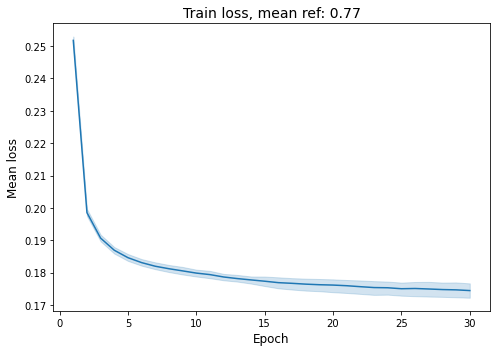

Index(['exp_name', 'index', 'labeled_valid_unseen_networks-val_loss'], dtype='object')
Index(['exp_name', 'index', 'labeled_valid_unseen_networks-val_loss_median'], dtype='object')


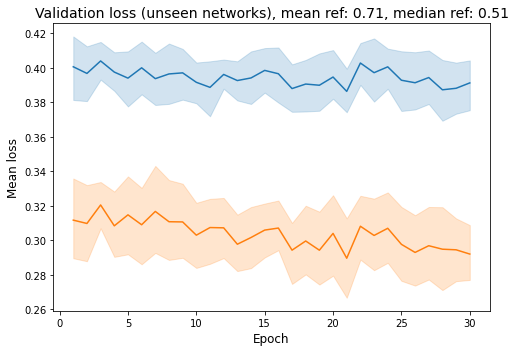

Index(['exp_name', 'index', 'labeled_valid_unseen_images-val_loss'], dtype='object')
Index(['exp_name', 'index', 'labeled_valid_unseen_images-val_loss_median'], dtype='object')


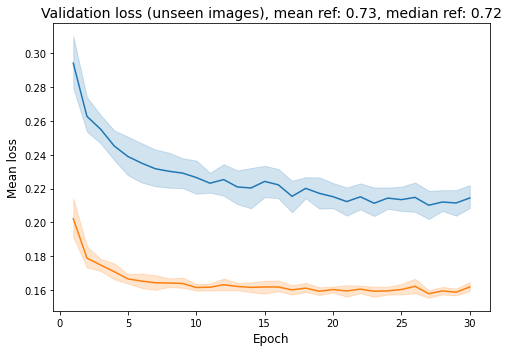

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

titles = ['Train loss', 'Validation loss (unseen networks)',
         'Validation loss (unseen images)',
         'Test loss (unseen images)',
         'Test loss (unseen images and networks)']

use_stats = '_median'
use_stats = ''

for run_column, ref_columns, sample_s, title in zip(shadow_columns, base_keys, sample_list, titles):
    plt.figure(figsize=(7,5))
    stats_title = ''
    
    for stats in [run_column, run_column + '_median']:
    
        if stats not in dfs.columns:
            continue

        run_data = dfs[['exp_name', 'index', stats]]
        print(run_data.columns)

        ref = base[ref_columns].iloc[1]

        if 'median' in stats:
            stats_title += f', median ref: {ref["median"].round(2)}'
        else:
            stats_title += f', mean ref: {ref["mean"].round(2)}'
            #ref_mean = ref['mean'].round(2)
            #ref_ci = ci_95(ref['std'], sample_s).round(2)
            #ref_title = f"${ref_mean} \pm {ref_ci}$"

        sns.lineplot(data=run_data, x='index', y=stats)
    #plt.hlines(ref_mean, 1, 30, colors='r')
    #plt.fill_between(np.arange(1, 31), ref_mean + ref_ci, ref_mean - ref_ci)
    
    plt.title(f"{title}{stats_title}", fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(f'{"Median" if "median" in use_stats else "Mean"} loss', fontsize=12)
    plt.tight_layout()
    #plt.savefig('test.png', dpi=1500)
    plt.show()

In [49]:
# Tohleto už stačí, test set budou boxploty, teď to samý pro recon acc a train loss 

,exp_name,index,labeled_labeled
0,with_ref_1,1,0.253823
1,with_ref_1,2,0.201816
2,with_ref_1,3,0.193596
3,with_ref_1,4,0.190007
4,with_ref_1,5,0.187761
...,...,...,...
25,with_ref_9,26,0.172180
26,with_ref_9,27,0.172187
27,with_ref_9,28,0.172097
28,with_ref_9,29,0.172164
